# <span style="color:DarkOliveGreen">LSTM Model for CDX.NA.IG

__Summary:__ <span style="color:Blue">Use LSTM model to fit and predict 

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

import pandas_datareader.data as web
import datetime

import matplotlib.pyplot as plt
from matplotlib import style
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from xbbg import blp, pipeline
# ignore warnings 
import warnings
warnings.filterwarnings('ignore')
import os
np.random.seed(0)

In [2]:
style.use('ggplot')
# User defined names
index = "CDX.NA.IG"
filename = "input_data.csv"
date_col = "Date"

In [3]:
# Get current working directory
mycwd = os.getcwd()
print(mycwd)

C:\Users\rsingh\Desktop\WorldQuant\Capstone\Draft Submission\MScFE_Capstone-main\Notebooks


In [4]:
# Change to data directory
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

#### <span style="color:DarkOliveGreen">Read input data as df:

In [5]:
# Read the data
df = pd.read_csv(filename, index_col=date_col)
#df.index = pd.to_datetime(df.index)
df.head()

,IG_BO,SPX,VIX,UST_3M,UST_6M,UST_1Y,UST_2Y,UST_3Y,UST_5Y,UST_7Y,UST_10Y,UST_20Y,UST_30Y,IG_MID
Date,,,,,,,,,,,,,,
2012-01-01,1.500,1257.61,23.40,0.02,0.06,0.12,0.25,0.36,0.83,1.35,1.89,2.57,2.89,120.000
2012-01-02,1.500,1257.61,23.40,0.02,0.06,0.12,0.25,0.36,0.83,1.35,1.89,2.57,2.89,120.000
2012-01-03,1.000,1277.06,22.97,0.02,0.06,0.12,0.27,0.40,0.89,1.41,1.97,2.67,2.98,118.000
2012-01-04,1.000,1277.30,22.22,0.02,0.06,0.12,0.25,0.40,0.89,1.43,2.00,2.71,3.03,118.750
2012-01-05,0.917,1281.06,21.48,0.02,0.07,0.11,0.27,0.40,0.88,1.43,2.02,2.74,3.06,120.001


In [6]:
print("shape:",df.shape)
print("first date:",df.index[0])
print("last date:",df.index[-1])

shape: (4018, 14)
first date: 2012-01-01
last date: 2022-12-31


#### <span style="color:DarkOliveGreen">Plotting our data and rolling mean:

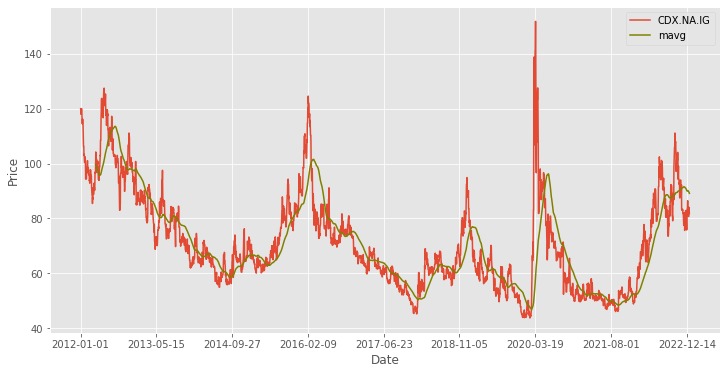

In [7]:
# Visualize the training stock data:
%matplotlib inline

# Rolling mean
close_px = df['IG_MID']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='CDX.NA.IG')
mavg.plot(label='mavg',color='olive')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

#### <span style="color:DarkOliveGreen">User-defined Functions

In [8]:
'''Function to prepare the dataset to feed into an LSTM model'''
def create_dataset(dataset_X, dataset_y, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset_X)-look_back):
        a = dataset_X[i:(i + look_back), ]
        dataX.append(a)
        b = dataset_y[i + look_back,  ][0]
        dataY.append(b)
    
    dataX, dataY = np.array(dataX), np.array(dataY)
        
    # reshape it [samples, time steps, features]
    dataX = np.reshape(dataX, (dataX.shape[0], look_back, dataX[0].shape[1]))
    dataY = np.reshape(dataY, (dataY.shape[0], 1, 1))
        
    return dataX, dataY

In [9]:
'''Function to evaluate a LSTM model with chosen parameters to help with hyper-parameter optimization'''
'''The output is a chosen performance metric i.e. rmse and a plot for model loss vs epochs'''
def run_lstm(X_train, y_train, epochs, batch_size, show_plots):
    # Build the model 
    model = keras.Sequential()

    model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], X_train[0].shape[1])))
    model.add(Dropout(0.3))

    model.add(LSTM(units = 100))
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(units = 1))

    # Compiling the model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the model to the Training set
    history = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, validation_split=.30,verbose=0)
    
    # Plot training & validation loss values
    if show_plots:
        plt.figure(figsize = (10,6))
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()
    
    
    # Fit the prices with the model
    y_train_ = y_train.reshape(y_train.shape[0],y_train[0].shape[1])
    org_y_train = scaler_y.inverse_transform(y_train_)

    fitted_y = model.predict(X_train)
    fitted_y = scaler_y.inverse_transform(fitted_y)

    # calculate RMSE
    rmse = np.sqrt(mean_squared_error(org_y_train[:,0], fitted_y[:,0]))
    print('Fit RMSE: %.3f' % rmse)
    
    # plot the results 
    if show_plots:
        plt.figure(figsize = (10,6))
        plt.plot(org_y_train[:,0], color = 'red', label = 'CDX.NA.IG')
        plt.plot(fitted_y[:,0], color = 'olive', label = 'Fitted CDX.NA.IG')

        plt.title('CDX.NA.IG Spread Prediction')
        plt.xlabel('Time')
        plt.ylabel('CDX.NA.IG')
        plt.legend()
        plt.show()
        
    return rmse

#### <span style="color:DarkOliveGreen">Feature selection

In [10]:
# Create predictor variables
df['SPOT'] = df.UST_3M
df['SLOPE'] = df.UST_10Y - df.UST_2Y
df['Days'] = [i for i in range(1,len(df.index)+1)]

# Store all predictor variables in a variable X
X = df[['IG_MID','SPX', 'VIX', 'SPOT', 'SLOPE','Days']]
X = df[['IG_MID']]
y = df[['IG_MID']]
X.head()

,IG_MID
Date,
2012-01-01,120.000
2012-01-02,120.000
2012-01-03,118.000
2012-01-04,118.750
2012-01-05,120.001


In [11]:
y.tail()

,IG_MID
Date,
2022-12-27,80.753
2022-12-28,84.111
2022-12-29,81.710
2022-12-30,82.024
2022-12-31,82.024


#### <span style="color:DarkOliveGreen">Normalizing our featureas and predicted data

In [12]:
# Apply normalization before feeding to LSTM using sklearn:
scaler_X = MinMaxScaler()
scaled_X = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
scaled_y = scaler_y.fit_transform(y)

#### <span style="color:DarkOliveGreen">Split selected data as train_df and test_df

In [13]:
train_scaled_X, test_scaled_X = train_test_split(scaled_X, test_size=0.1, shuffle=False)
train_scaled_y, test_scaled_y = train_test_split(scaled_y, test_size=0.1, shuffle=False)

#### <span style="color:DarkOliveGreen"> Preparing our training and testing data for the neural network:

In [14]:
# Create the data to train our model on:
time_steps = 1
X_train, y_train = create_dataset(train_scaled_X, train_scaled_y, time_steps)
X_test, y_test = create_dataset(test_scaled_X, test_scaled_y, time_steps)

print(y_train.shape)

# Visualizing our data with prints: 
print('X_train:')
print(str(scaler_X.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler_y.inverse_transform(y_train[0]))+'\n')

(3615, 1, 1)
X_train:
[[120.]]


y_train: [[120.]]



 #### <span style="color:DarkOliveGreen"> Building the LSTM model:

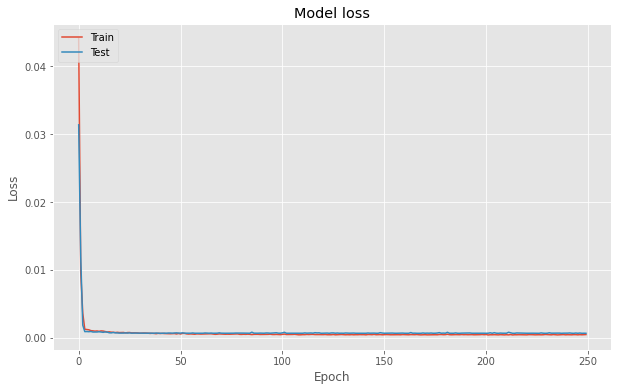

In [15]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], X_train[0].shape[1])))
model.add(Dropout(0.3))

model.add(LSTM(units = 100))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 250, batch_size = 64, validation_split=.30,verbose=0)

# Plot training & validation loss values
plt.figure(figsize = (10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

#### <span style="color:DarkOliveGreen"> See the fit and making the prediction:

In [16]:
# Predict the prices with the model
train_len = X_train.shape[0]

y_train_ = y_train.reshape(y_train.shape[0],y_train[0].shape[1])
y_test_ = y_test.reshape(y_test.shape[0],y_test[0].shape[1])

org_y_train = scaler_y.inverse_transform(y_train_)
org_y_test = scaler_y.inverse_transform(y_test_)

fitted_y = model.predict(X_train)
predicted_y = model.predict(X_test)

fitted_y = scaler_y.inverse_transform(fitted_y)
predicted_y = scaler_y.inverse_transform(predicted_y)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(org_y_train[:,0], fitted_y[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.002


In [17]:
train_dates = [datetime.datetime.strptime(dt, '%Y-%m-%d').date() for dt in X.index[:train_len]]
test_dates = [datetime.datetime.strptime(dt, '%Y-%m-%d').date() for dt in X.index[train_len+time_steps+1:]]

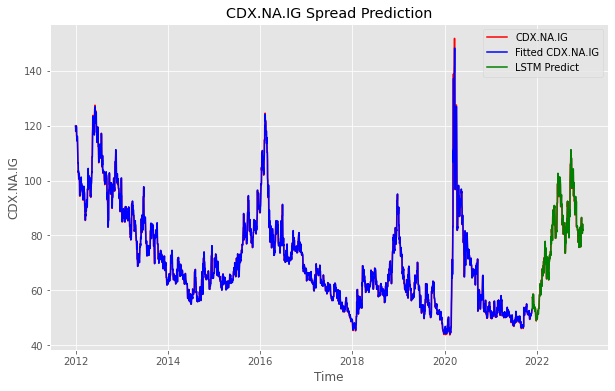

In [18]:
# plot the results 
plt.figure(figsize = (10,6))
plt.plot(train_dates, org_y_train[:,0], color = 'red', label = 'CDX.NA.IG')
plt.plot(train_dates, fitted_y[:,0], color = 'blue', label = 'Fitted CDX.NA.IG')

plt.plot(test_dates, org_y_test[:,0], color = 'red')
plt.plot(test_dates, predicted_y[:,0], color = 'green', label = 'LSTM Predict')

plt.title('CDX.NA.IG Spread Prediction')
plt.xlabel('Time')
plt.ylabel('CDX.NA.IG')
plt.legend()
plt.show()

## <span style="color:DarkOliveGreen">Hyper-parameter tuning

In [19]:
#We will do a brute force grid-search to arrive at the optimal hyper-parameters
look_backs = [1,2,3,4,5,10]
epochs_list = [10,50,100,250,500,750,1000]
batch_sizes = [8,32,64,96,128,256]
look_backs = [1,4,10,25,50]

### <span style="color:DarkOliveGreen"> Parameter 1: Optimal look_back for LSTM

In [20]:
epochs = 250
batch_size = 64

show_plots = False
look_back_rmses = []
for time_steps in look_backs:
    X_train, y_train = create_dataset(train_scaled_X, train_scaled_y, time_steps)
    rmse = run_lstm(X_train, y_train, epochs, batch_size, show_plots)
    look_back_rmses.append(rmse)

Fit RMSE: 2.026
Fit RMSE: 2.089
Fit RMSE: 2.095
Fit RMSE: 2.076
Fit RMSE: 2.040


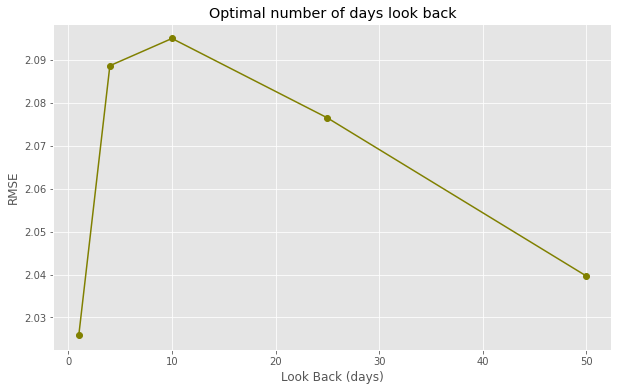

In [21]:
plt.figure(figsize = (10,6))
plt.plot(look_backs, look_back_rmses , color = 'olive',marker='o')
plt.title('Optimal number of days look back')
plt.xlabel('Look Back (days)')
plt.ylabel('RMSE')
plt.show()

We think a look back period of 1 looks optimal as in it gives the best fit as seen from the least RMSE value.

Next we tune the epochs.

#### <span style="color:DarkOliveGreen"> Parameter 2: Optimal epochs for LSTM

In [22]:
look_backs = 1
epochs = 250
batch_size = 64

X_train, y_train = create_dataset(train_scaled_X, train_scaled_y, look_backs)

show_plots = False
epoch_rmses = []
for epochs in epochs_list:
    rmse = run_lstm(X_train, y_train, epochs, batch_size, show_plots)
    epoch_rmses.append(rmse)

Fit RMSE: 2.265
Fit RMSE: 2.015
Fit RMSE: 2.159
Fit RMSE: 2.030
Fit RMSE: 2.015
Fit RMSE: 2.221
Fit RMSE: 2.061


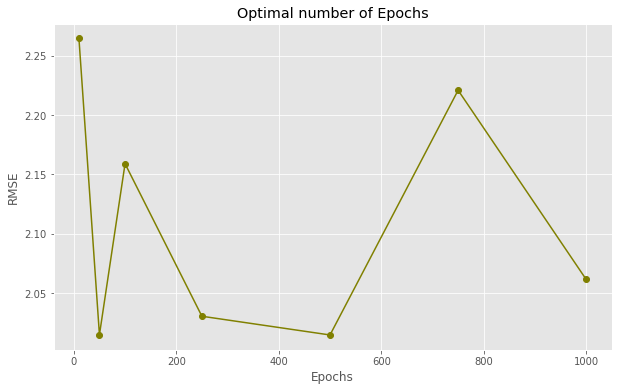

In [23]:
plt.figure(figsize = (10,6))
plt.plot(epochs_list, epoch_rmses , color = 'olive',marker='o')
plt.title('Optimal number of Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.show()

#### <span style="color:DarkOliveGreen"> Parameter 3: Optimal bactch_size for LSTM

In [25]:
look_backs = 1
epochs = 250
batch_size = 96

X_train, y_train = create_dataset(train_scaled_X, train_scaled_y, look_backs)

show_plots = False
batch_size_rmses = []
for batch_size in batch_sizes:
    rmse = run_lstm(X_train, y_train, epochs, batch_size, show_plots)
    batch_size_rmses.append(rmse)

Fit RMSE: 2.242
Fit RMSE: 2.129
Fit RMSE: 2.058
Fit RMSE: 2.038
Fit RMSE: 2.008
Fit RMSE: 2.016


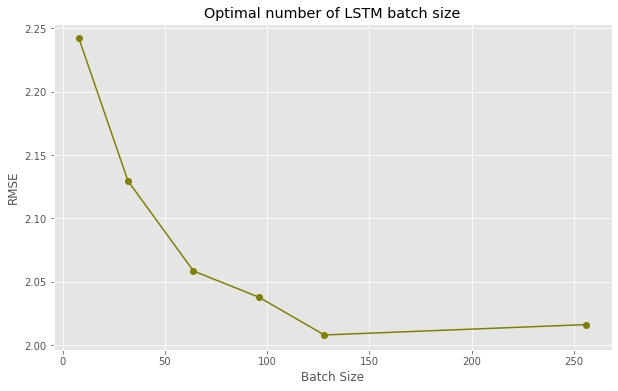

In [26]:
plt.figure(figsize = (10,6))
plt.plot(batch_sizes, batch_size_rmses , color = 'olive',marker='o')
plt.title('Optimal number of LSTM batch size')
plt.xlabel('Batch Size')
plt.ylabel('RMSE')
plt.show()

Looking at the root mean squared error plots for various parameters we think the optimal choices are as below:
1. look_backs = 1
2. epochs = 250
3. batch_size = 96

## <span style="color:DarkOliveGreen">FINALISED LSTM MODEL

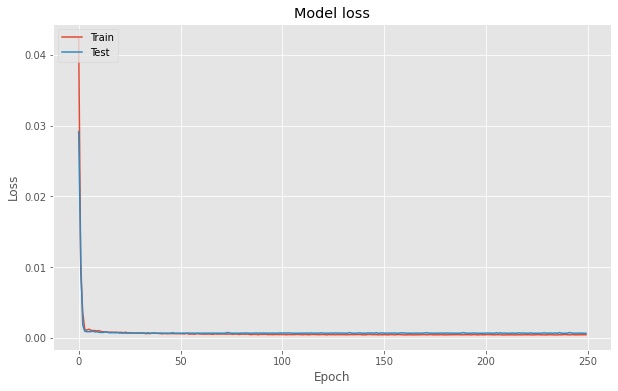

Fit RMSE: 2.017


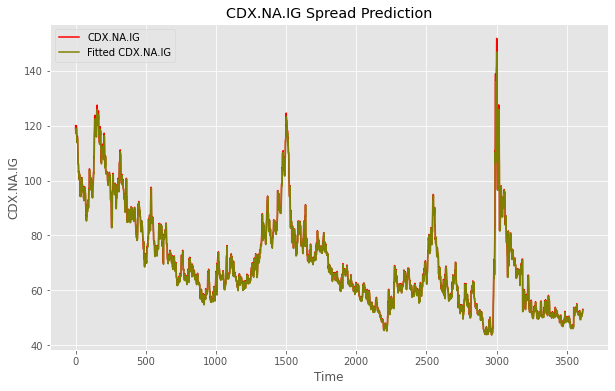

2.016664750227756

In [27]:
look_backs = 1
epochs = 250
batch_size = 64

X_train, y_train = create_dataset(train_scaled_X, train_scaled_y, look_backs)

show_plots = True
run_lstm(X_train, y_train, epochs, batch_size, show_plots)

Test RMSE: 2.217


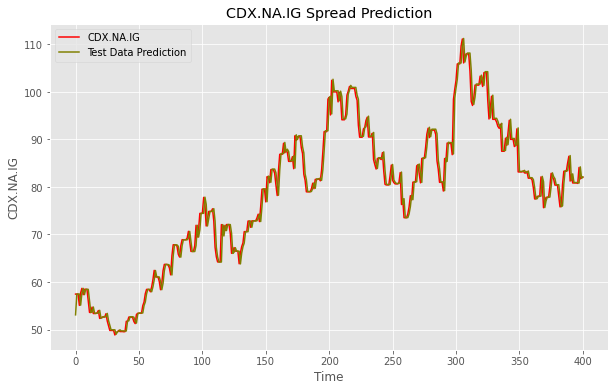

In [28]:
# Predict the prices with the model over the test data
y_test_ = y_test.reshape(y_test.shape[0],y_test[0].shape[1])
org_y_test = scaler_y.inverse_transform(y_test_)
predicted_y = model.predict(X_test)
predicted_y = scaler_y.inverse_transform(predicted_y)

# calculate RMSE
rmse = np.sqrt(mean_squared_error(org_y_test[:,0], predicted_y[:,0]))
print('Test RMSE: %.3f' % rmse)

# plot the results 
plt.figure(figsize = (10,6))

plt.plot(org_y_test[:,0], color = 'red', label = 'CDX.NA.IG')
plt.plot(predicted_y[:,0], color = 'olive', label = 'Test Data Prediction')

plt.title('CDX.NA.IG Spread Prediction')
plt.xlabel('Time')
plt.ylabel('CDX.NA.IG')
plt.legend()
plt.show()

### <span style="color:DarkOliveGreen">Save the Data

In [29]:
os.chdir("..")
os.chdir(str(os.getcwd()) + "\\Data")

In [30]:
train_res = pd.DataFrame(index=train_dates)
train_res['IG_MID'] = org_y_train[:,0]
train_res['lstm_fit'] = fitted_y[:,0]
train_res.to_csv("lstm_train_res"+".csv", index=True)

In [31]:
train_res.head()

,IG_MID,lstm_fit
2012-01-01,120.000,119.818817
2012-01-02,118.000,119.818817
2012-01-03,118.750,117.902855
2012-01-04,120.001,118.622711
2012-01-05,120.000,119.819771


In [32]:
test_res = pd.DataFrame(index=test_dates)
test_res['IG_MID'] = org_y_test[:,0]
test_res['lstm_predict'] = predicted_y[:,0]
test_res.to_csv("lstm_test_res"+".csv", index=True)

In [33]:
test_res.head()

,IG_MID,lstm_predict
2021-11-26,57.454,53.086491
2021-11-27,57.454,57.459648
2021-11-28,57.454,57.459648
2021-11-29,55.083,57.459648
2021-11-30,57.687,55.116882
